# Explicabilidade

## Imports

In [1]:
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

random.seed(1729)

In [2]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

## Dados

In [3]:
df = pd.read_csv('waitlist_kidney_sensitive_pairs.csv', encoding='iso-8859-1')
df.head()

date_registered_a  age_registered_a  dialysis_session_count_a  diabetes_a  \
0            13629.0                28                      60.0        True   
1            14463.0                28                      10.0        True   
2            15614.0                32                      38.0        True   
3            13063.0                35                      11.0        True   
4            11248.0                60                       5.0        True   

   chagas_a  transfusion_count_a  gestation_a  prior_transplant_a  c_pra_a  \
0     False                    0        False                True       19   
1     False                    0         True               False        0   
2     False                    1         True               False       37   
3     False                    0        False               False        0   
4     False                    0        False               False        0   

   hla_a1_a  ...  sex_M_b  a_00_homozygous_b  b_00_homozygous_b  \
0         3  ...     True              False              False   
1         2  ...     True              False              False   
2         1  ...     True              False              False   
3        24  ...    False               True              False   
4         0  ...     True              False              False   

   underlying_disease_glomerulonephritis_b  underlying_disease_hypertension_b  \
0                                    False                              False   
1                                    False                              False   
2                                    False                              False   
3                                     True                              False   
4                                    False                              False   

   underlying_disease_other_b  underlying_disease_pyelonephritis_b  race_b  \
0                        True                                False  Branca   
1                       False                                False  Branca   
2                        True                                False  Branca   
3                       False                                False  Branca   
4                        True                                False  Branca   

   sex_b transplanted_first  
0      M               True  
1      M              False  
2      M              False  
3      F              False  
4      M              False  

[5 rows x 73 columns]

In [4]:
def X_y_meta_split(df: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    target = 'transplanted_first'
    _meta = ['date_registered_a', 'date_registered_b','days_waiting_a', 'days_waiting_b', 'date_transplanted_a', 'date_transplanted_b', 'sex_a', 'sex_b', 'race_a', 'race_b']
    return df.drop(columns=[target, *_meta]), df[target], df[_meta]

X, y, meta = X_y_meta_split(df)

X_train,X_test,y_train,y_test,meta_train,meta_test = train_test_split(X,y,meta,test_size=0.2)

## Modelo baseline

Random Forest com Correlation Remover
Decidi usar Correlation Remover para todos os modelos

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [6]:
rf = RandomForestClassifier(1500, min_samples_split=2, max_features='log2', random_state=1729)
rf.fit(X_train, y_train)

RandomForestClassifier(max_features='log2', n_estimators=1500,
                       random_state=1729)

In [7]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [8]:
rf_prob = rf.predict_proba(X_test)
(accuracy_score(y_test, rf_prob[:,1] >= 0.5), roc_auc_score(y_test,rf_prob[:,1]))

(0.752025, 0.8372988485299777)

## Modelo interpretável

Árvore de Decisão com profundidade 5 (max. 32 decisões)

In [9]:
dt = DecisionTreeClassifier(max_depth=5, random_state=1729)
dt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5, random_state=1729)

In [10]:
dt_prob = dt.predict_proba(X_test)
(accuracy_score(y_test, dt_prob[:,1] >= 0.5), roc_auc_score(y_test,dt_prob[:,1]))

(0.612575, 0.6250025945510477)

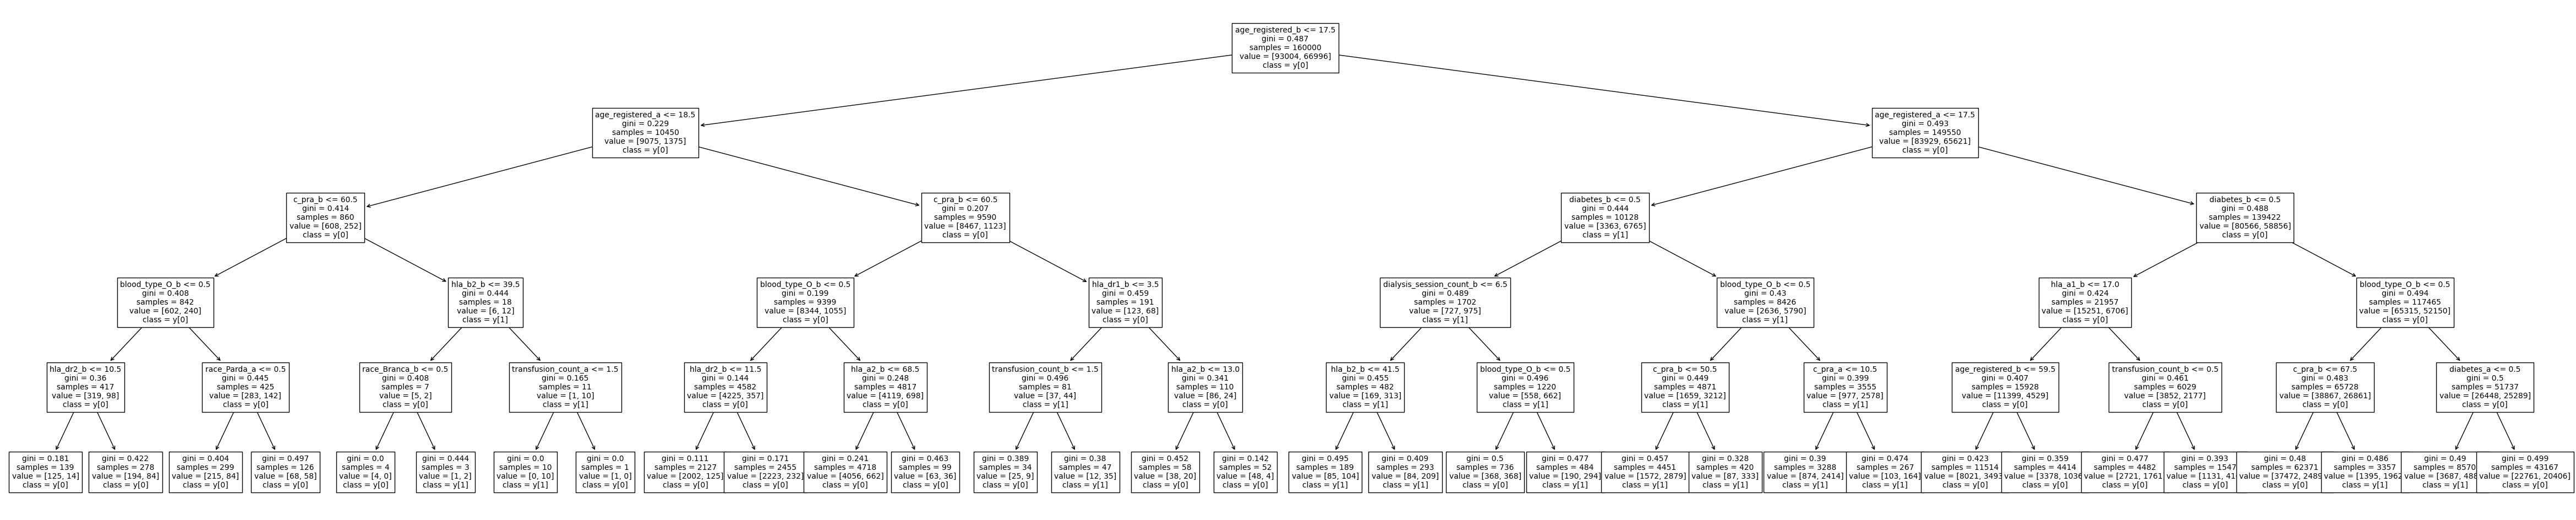

In [11]:
from sklearn.tree import plot_tree
plt.figure(figsize=(60,12))
plot_tree(dt, fontsize=10, feature_names=X.columns,class_names=True)
plt.savefig('dt', dpi=100)

In [12]:
rf_prob_train = rf.predict_proba(X_train)
dt_prob_train = dt.predict_proba(X_train)

## Aproximações

### Global

Utilizei o SRatio como explicado em 12.4.1 no livro

Porém, inverti a ponderação porque sem isso o modelo ficou muito ruim. Para o recorde, contra o dado original obtivemos (0.4356, 0.6266) (ACC, AUC) e contra a Random Forest obtivemos (0.3057, 0.7557) (a AUC ficou alta, o que indica que talvez valesse a pena calibrar, mas eu fiquei com preguiça)

In [13]:
W_train_sratio = dt_prob_train[:,1] / rf_prob_train[:,1]

In [14]:
dtw = DecisionTreeClassifier(max_depth=5, random_state=1729)
dtw.fit(X_train, y_train, W_train_sratio)

DecisionTreeClassifier(max_depth=5, random_state=1729)

In [15]:
dtw_prob = dtw.predict_proba(X_test)
(accuracy_score(y_test, dtw_prob[:,1] >= 0.5), roc_auc_score(y_test,dtw_prob[:,1]))

(0.578925, 0.6240604517666506)

In [16]:
(accuracy_score(rf_prob[:,1] >= 0.5, dtw_prob[:,1] >= 0.5), roc_auc_score(rf_prob[:,1] >= 0.5,dtw_prob[:,1]))

(0.70745, 0.7582016301128306)

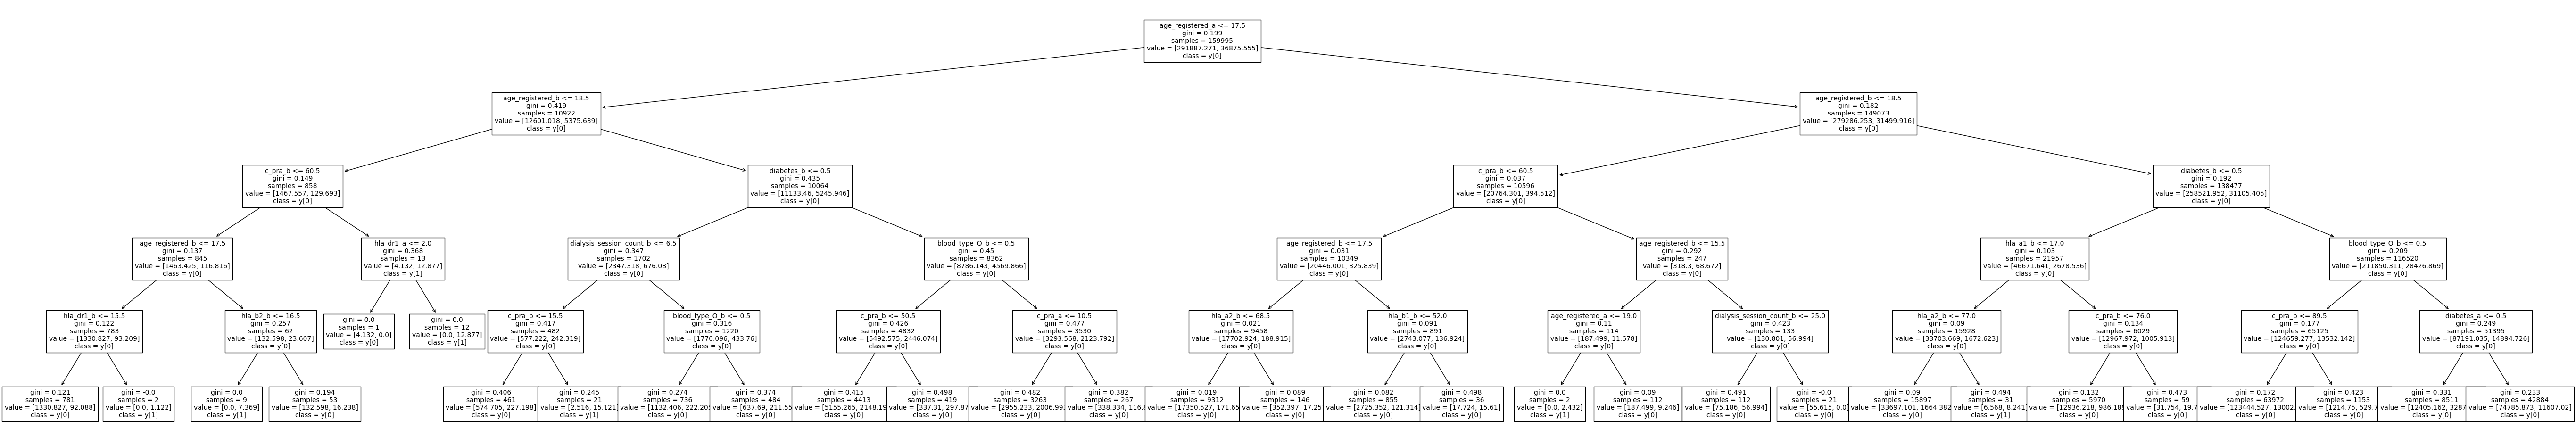

In [17]:
from sklearn.tree import plot_tree
plt.figure(figsize=(70,12))
plot_tree(dtw, fontsize=10, feature_names=X.columns,class_names=True)
plt.savefig('dtw', dpi=100)

### Local

Vamos utilizar ~~SHAP~~ LIME :)

(Eu deixei o SHAP rodando por 4 horas e ele não terminou, então decidi usar LIME :p)

In [18]:
import lime
from lime import lime_tabular

import numpy as np

In [20]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns,
    class_names=['0', '1'],
    mode='classification'
)

In [21]:
from sklearn.utils import resample

In [22]:
exp = explainer.explain_instance(
    data_row=X_test.iloc[1], 
    predict_fn=rf.predict_proba
)

exp.show_in_notebook(show_table=True)

/home/pochete/studies/2023s2/ia2/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [29]:
chosen = random.randint(0,len(X_test))
print(chosen)
exp = explainer.explain_instance(
    data_row=X_test.iloc[chosen], 
    predict_fn=rf.predict_proba
)

exp.show_in_notebook(show_table=True)

3812


/home/pochete/studies/2023s2/ia2/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [30]:
chosen = random.randint(0,len(X_test))
print(chosen)
exp = explainer.explain_instance(
    data_row=X_test.iloc[chosen], 
    predict_fn=rf.predict_proba
)

exp.show_in_notebook(show_table=True)

11961


/home/pochete/studies/2023s2/ia2/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [28]:
chosen = random.randint(0,len(X_test))
print(chosen)
exp = explainer.explain_instance(
    data_row=X_test.iloc[chosen], 
    predict_fn=rf.predict_proba
)

exp.show_in_notebook(show_table=True)

11118


/home/pochete/studies/2023s2/ia2/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


## Contrafactual

In [31]:
import dice_ml

In [41]:
continuous_features=['age_registered_a', 'dialysis_session_count_a',
       'transfusion_count_a', 'c_pra_a', 'hla_a1_a', 'hla_a2_a', 'hla_b1_a', 'hla_b2_a', 'hla_dr1_a',
       'hla_dr2_a','age_registered_b', 'dialysis_session_count_b',
       'transfusion_count_b', 'c_pra_b', 'hla_a1_b', 'hla_a2_b', 'hla_b1_b', 'hla_b2_b', 'hla_dr1_b',
       'hla_dr2_b']

In [61]:
d = dice_ml.Data(dataframe=pd.concat([X.astype(float),y], axis=1),continuous_features=continuous_features,outcome_name='transplanted_first')

In [62]:
m = dice_ml.Model(model=rf, backend='sklearn')

In [63]:
exp = dice_ml.Dice(d, m)

In [64]:
pd.set_option('display.max_columns', None)

In [65]:
e1 = exp.generate_counterfactuals(X_test.astype(float)[2:3], total_CFs=2, desired_class="opposite")
e1.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

Query instance (original outcome : 1)


age_registered_a  dialysis_session_count_a diabetes_a chagas_a  \
0              16.0                       8.0        1.0      0.0   

   transfusion_count_a gestation_a prior_transplant_a  c_pra_a  hla_a1_a  \
0                  0.0         0.0                0.0      0.0       1.0   

   hla_a2_a  hla_b1_a  hla_b2_a  hla_dr1_a  hla_dr2_a anti_hbc_a anti_hcv_a  \
0      68.0      15.0      55.0        4.0        7.0        0.0        0.0   

  hbs_ag_a race_Branca_a race_Negra_a race_Parda_a dr_00_homozygous_a  \
0      0.0           0.0          0.0          1.0                0.0   

  blood_type_AB_a blood_type_B_a blood_type_O_a sex_M_a a_00_homozygous_a  \
0             0.0            0.0            0.0     0.0               0.0   

  b_00_homozygous_a underlying_disease_glomerulonephritis_a  \
0               0.0                                     0.0   

  underlying_disease_hypertension_a underlying_disease_other_a  \
0                               0.0                        1.0   

  underlying_disease_pyelonephritis_a  age_registered_b  \
0                                 0.0              63.0   

   dialysis_session_count_b diabetes_b chagas_b  transfusion_count_b  \
0                      96.0        1.0      0.0                  0.0   

  gestation_b prior_transplant_b  c_pra_b  hla_a1_b  hla_a2_b  hla_b1_b  \
0         1.0                1.0      0.0       3.0      24.0      14.0   

   hla_b2_b  hla_dr1_b  hla_dr2_b anti_hbc_b anti_hcv_b hbs_ag_b  \
0      45.0        1.0       14.0        0.0        0.0      0.0   

  race_Branca_b race_Negra_b race_Parda_b dr_00_homozygous_b blood_type_AB_b  \
0           1.0          0.0          0.0                0.0             0.0   

  blood_type_B_b blood_type_O_b sex_M_b a_00_homozygous_b b_00_homozygous_b  \
0            0.0            0.0     0.0               0.0               0.0   

  underlying_disease_glomerulonephritis_b underlying_disease_hypertension_b  \
0                                     0.0                               0.0   

  underlying_disease_other_b underlying_disease_pyelonephritis_b  \
0                        1.0                                 0.0   

   transplanted_first  
0                   1


Diverse Counterfactual set (new outcome: 0.0)


age_registered_a dialysis_session_count_a diabetes_a chagas_a  \
0             41.9                        -        1.0      0.0   
1             60.2                        -        1.0      0.0   

  transfusion_count_a gestation_a prior_transplant_a c_pra_a hla_a1_a  \
0                   -         0.0                0.0       -        -   
1                   -         0.0                0.0       -        -   

  hla_a2_a hla_b1_a hla_b2_a hla_dr1_a hla_dr2_a anti_hbc_a anti_hcv_a  \
0        -        -        -         -         -        0.0        0.0   
1        -        -        -         -         -        0.0        0.0   

  hbs_ag_a race_Branca_a race_Negra_a race_Parda_a dr_00_homozygous_a  \
0      0.0           0.0          0.0          1.0                0.0   
1      0.0           0.0          0.0          1.0                0.0   

  blood_type_AB_a blood_type_B_a blood_type_O_a sex_M_a a_00_homozygous_a  \
0             0.0            0.0            0.0     0.0               0.0   
1             0.0            0.0            0.0     0.0               0.0   

  b_00_homozygous_a underlying_disease_glomerulonephritis_a  \
0               0.0                                     0.0   
1               0.0                                     0.0   

  underlying_disease_hypertension_a underlying_disease_other_a  \
0                               0.0                        1.0   
1                               0.0                        1.0   

  underlying_disease_pyelonephritis_a age_registered_b  \
0                                 0.0                -   
1                                 0.0                -   

  dialysis_session_count_b diabetes_b chagas_b transfusion_count_b  \
0                        -        1.0      0.0                   -   
1                        -        1.0      0.0                   -   

  gestation_b prior_transplant_b c_pra_b hla_a1_b hla_a2_b hla_b1_b hla_b2_b  \
0         1.0                1.0       -        -        -        -        -   
1         1.0                1.0       -        -        -        -        -   

  hla_dr1_b hla_dr2_b anti_hbc_b anti_hcv_b hbs_ag_b race_Branca_b  \
0         -         -        0.0        1.0      0.0           1.0   
1         -         -        0.0        0.0      0.0           1.0   

  race_Negra_b race_Parda_b dr_00_homozygous_b blood_type_AB_b blood_type_B_b  \
0          0.0          0.0                0.0             0.0            0.0   
1          1.0          0.0                0.0             0.0            0.0   

  blood_type_O_b sex_M_b a_00_homozygous_b b_00_homozygous_b  \
0            0.0     0.0               0.0               0.0   
1            0.0     0.0               0.0               0.0   

  underlying_disease_glomerulonephritis_b underlying_disease_hypertension_b  \
0                                     0.0                               0.0   
1                                     0.0                               0.0   

  underlying_disease_other_b underlying_disease_pyelonephritis_b  \
0                        1.0                                 0.0   
1                        1.0                                 0.0   

  transplanted_first  
0                  0  
1                  0

In [68]:
chosen = random.randint(0,X_test.shape[0])
print(chosen)
e1 = exp.generate_counterfactuals(X_test.astype(float)[chosen:chosen+1], total_CFs=2, desired_class="opposite")
e1.visualize_as_dataframe(show_only_changes=True)

38115


100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

Query instance (original outcome : 0)


age_registered_a  dialysis_session_count_a diabetes_a chagas_a  \
0              45.0                       4.0        0.0      0.0   

   transfusion_count_a gestation_a prior_transplant_a  c_pra_a  hla_a1_a  \
0                  1.0         0.0                0.0      0.0      11.0   

   hla_a2_a  hla_b1_a  hla_b2_a  hla_dr1_a  hla_dr2_a anti_hbc_a anti_hcv_a  \
0       0.0      14.0      51.0        1.0        7.0        0.0        0.0   

  hbs_ag_a race_Branca_a race_Negra_a race_Parda_a dr_00_homozygous_a  \
0      0.0           1.0          0.0          0.0                0.0   

  blood_type_AB_a blood_type_B_a blood_type_O_a sex_M_a a_00_homozygous_a  \
0             0.0            0.0            1.0     1.0               1.0   

  b_00_homozygous_a underlying_disease_glomerulonephritis_a  \
0               0.0                                     0.0   

  underlying_disease_hypertension_a underlying_disease_other_a  \
0                               0.0                        0.0   

  underlying_disease_pyelonephritis_a  age_registered_b  \
0                                 0.0              41.0   

   dialysis_session_count_b diabetes_b chagas_b  transfusion_count_b  \
0                      59.0        1.0      0.0                  0.0   

  gestation_b prior_transplant_b  c_pra_b  hla_a1_b  hla_a2_b  hla_b1_b  \
0         1.0                0.0     42.0      24.0      30.0      14.0   

   hla_b2_b  hla_dr1_b  hla_dr2_b anti_hbc_b anti_hcv_b hbs_ag_b  \
0      40.0        8.0       15.0        0.0        0.0      0.0   

  race_Branca_b race_Negra_b race_Parda_b dr_00_homozygous_b blood_type_AB_b  \
0           1.0          0.0          0.0                0.0             0.0   

  blood_type_B_b blood_type_O_b sex_M_b a_00_homozygous_b b_00_homozygous_b  \
0            0.0            1.0     0.0               0.0               0.0   

  underlying_disease_glomerulonephritis_b underlying_disease_hypertension_b  \
0                                     0.0                               0.0   

  underlying_disease_other_b underlying_disease_pyelonephritis_b  \
0                        1.0                                 0.0   

   transplanted_first  
0                   0


Diverse Counterfactual set (new outcome: 1.0)


age_registered_a dialysis_session_count_a diabetes_a chagas_a  \
0                -                        -        0.0      0.0   
1              0.4                        -        0.0      0.0   

  transfusion_count_a gestation_a prior_transplant_a c_pra_a hla_a1_a  \
0                   -         0.0                0.0       -        -   
1                   -         0.0                0.0       -        -   

  hla_a2_a hla_b1_a hla_b2_a hla_dr1_a hla_dr2_a anti_hbc_a anti_hcv_a  \
0        -        -        -         -         -        0.0        0.0   
1        -        -     47.4         -         -        0.0        0.0   

  hbs_ag_a race_Branca_a race_Negra_a race_Parda_a dr_00_homozygous_a  \
0      0.0           1.0          0.0          0.0                0.0   
1      0.0           1.0          0.0          0.0                0.0   

  blood_type_AB_a blood_type_B_a blood_type_O_a sex_M_a a_00_homozygous_a  \
0             0.0            0.0            1.0     1.0               1.0   
1             0.0            0.0            1.0     1.0               1.0   

  b_00_homozygous_a underlying_disease_glomerulonephritis_a  \
0               0.0                                     0.0   
1               0.0                                     0.0   

  underlying_disease_hypertension_a underlying_disease_other_a  \
0                               0.0                        0.0   
1                               0.0                        0.0   

  underlying_disease_pyelonephritis_a age_registered_b  \
0                                 0.0                -   
1                                 0.0                -   

  dialysis_session_count_b diabetes_b chagas_b transfusion_count_b  \
0                        -        1.0      0.0                   -   
1                        -        1.0      0.0                   -   

  gestation_b prior_transplant_b c_pra_b hla_a1_b hla_a2_b hla_b1_b hla_b2_b  \
0         1.0                0.0    91.0        -        -        -        -   
1         1.0                0.0       -        -        -        -        -   

  hla_dr1_b hla_dr2_b anti_hbc_b anti_hcv_b hbs_ag_b race_Branca_b  \
0         -         -        0.0        0.0      0.0           1.0   
1         -         -        0.0        0.0      0.0           1.0   

  race_Negra_b race_Parda_b dr_00_homozygous_b blood_type_AB_b blood_type_B_b  \
0          0.0          0.0                0.0             0.0            0.0   
1          0.0          0.0                0.0             0.0            0.0   

  blood_type_O_b sex_M_b a_00_homozygous_b b_00_homozygous_b  \
0              -     0.0               0.0               0.0   
1            1.0     0.0               0.0               0.0   

  underlying_disease_glomerulonephritis_b underlying_disease_hypertension_b  \
0                                     0.0                               0.0   
1                                     0.0                               0.0   

  underlying_disease_other_b underlying_disease_pyelonephritis_b  \
0                        1.0                                 0.0   
1                        1.0                                 0.0   

  transplanted_first  
0                  1  
1                  1

In [69]:
chosen = random.randint(0,X_test.shape[0])
print(chosen)
e1 = exp.generate_counterfactuals(X_test.astype(float)[chosen:chosen+1], total_CFs=2, desired_class="opposite")
e1.visualize_as_dataframe(show_only_changes=True)

28488


100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

Query instance (original outcome : 0)


age_registered_a  dialysis_session_count_a diabetes_a chagas_a  \
0              28.0                      79.0        1.0      0.0   

   transfusion_count_a gestation_a prior_transplant_a  c_pra_a  hla_a1_a  \
0                  1.0         0.0                0.0      0.0      24.0   

   hla_a2_a  hla_b1_a  hla_b2_a  hla_dr1_a  hla_dr2_a anti_hbc_a anti_hcv_a  \
0      36.0      35.0      53.0        7.0        9.0        0.0        0.0   

  hbs_ag_a race_Branca_a race_Negra_a race_Parda_a dr_00_homozygous_a  \
0      0.0           0.0          0.0          1.0                0.0   

  blood_type_AB_a blood_type_B_a blood_type_O_a sex_M_a a_00_homozygous_a  \
0             0.0            0.0            0.0     1.0               0.0   

  b_00_homozygous_a underlying_disease_glomerulonephritis_a  \
0               0.0                                     0.0   

  underlying_disease_hypertension_a underlying_disease_other_a  \
0                               1.0                        0.0   

  underlying_disease_pyelonephritis_a  age_registered_b  \
0                                 0.0              10.0   

   dialysis_session_count_b diabetes_b chagas_b  transfusion_count_b  \
0                      16.0        1.0      0.0                  1.0   

  gestation_b prior_transplant_b  c_pra_b  hla_a1_b  hla_a2_b  hla_b1_b  \
0         0.0                0.0      0.0       3.0      30.0      42.0   

   hla_b2_b  hla_dr1_b  hla_dr2_b anti_hbc_b anti_hcv_b hbs_ag_b  \
0      44.0        7.0        8.0        0.0        0.0      0.0   

  race_Branca_b race_Negra_b race_Parda_b dr_00_homozygous_b blood_type_AB_b  \
0           1.0          0.0          0.0                0.0             0.0   

  blood_type_B_b blood_type_O_b sex_M_b a_00_homozygous_b b_00_homozygous_b  \
0            0.0            1.0     0.0               0.0               0.0   

  underlying_disease_glomerulonephritis_b underlying_disease_hypertension_b  \
0                                     0.0                               0.0   

  underlying_disease_other_b underlying_disease_pyelonephritis_b  \
0                        1.0                                 0.0   

   transplanted_first  
0                   0


Diverse Counterfactual set (new outcome: 1.0)


age_registered_a dialysis_session_count_a diabetes_a chagas_a  \
0                -                        -        1.0      0.0   
1                -                        -        1.0      0.0   

  transfusion_count_a gestation_a prior_transplant_a c_pra_a hla_a1_a  \
0                   -         0.0                0.0       -     60.2   
1                   -         0.0                0.0       -        -   

  hla_a2_a hla_b1_a hla_b2_a hla_dr1_a hla_dr2_a anti_hbc_a anti_hcv_a  \
0        -        -        -         -         -        0.0        0.0   
1        -        -        -         -         -        0.0        0.0   

  hbs_ag_a race_Branca_a race_Negra_a race_Parda_a dr_00_homozygous_a  \
0      0.0           0.0          0.0          1.0                0.0   
1      0.0           0.0          0.0          1.0                0.0   

  blood_type_AB_a blood_type_B_a blood_type_O_a sex_M_a a_00_homozygous_a  \
0             0.0            0.0            0.0     1.0               0.0   
1             0.0            0.0              -     1.0               0.0   

  b_00_homozygous_a underlying_disease_glomerulonephritis_a  \
0               0.0                                     0.0   
1               0.0                                     0.0   

  underlying_disease_hypertension_a underlying_disease_other_a  \
0                               1.0                        0.0   
1                               1.0                        0.0   

  underlying_disease_pyelonephritis_a age_registered_b  \
0                                 0.0             41.8   
1                                 0.0             43.6   

  dialysis_session_count_b diabetes_b chagas_b transfusion_count_b  \
0                        -        1.0      0.0                   -   
1                        -        1.0      0.0                   -   

  gestation_b prior_transplant_b c_pra_b hla_a1_b hla_a2_b hla_b1_b hla_b2_b  \
0         0.0                0.0       -        -        -        -        -   
1         0.0                0.0       -        -        -        -        -   

  hla_dr1_b hla_dr2_b anti_hbc_b anti_hcv_b hbs_ag_b race_Branca_b  \
0         -         -        0.0        0.0      0.0           1.0   
1         -         -        0.0        0.0      0.0           1.0   

  race_Negra_b race_Parda_b dr_00_homozygous_b blood_type_AB_b blood_type_B_b  \
0          0.0          0.0                0.0             0.0            0.0   
1          0.0          0.0                0.0             0.0            0.0   

  blood_type_O_b sex_M_b a_00_homozygous_b b_00_homozygous_b  \
0            1.0     0.0               0.0               0.0   
1            1.0     0.0               0.0               0.0   

  underlying_disease_glomerulonephritis_b underlying_disease_hypertension_b  \
0                                     0.0                               0.0   
1                                     0.0                               0.0   

  underlying_disease_other_b underlying_disease_pyelonephritis_b  \
0                        1.0                                 0.0   
1                        1.0                                 0.0   

  transplanted_first  
0                  1  
1                  1

In [70]:
a_columns = [c for c in X.columns if c.endswith('_a')]

In [71]:
chosen = random.randint(0,X_test.shape[0])
print(chosen)
e1 = exp.generate_counterfactuals(X_test.astype(float)[chosen:chosen+1], total_CFs=2, desired_class="opposite",features_to_vary=a_columns)
e1.visualize_as_dataframe(show_only_changes=True)

869


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

Query instance (original outcome : 0)


age_registered_a  dialysis_session_count_a diabetes_a chagas_a  \
0              39.0                       4.0        1.0      0.0   

   transfusion_count_a gestation_a prior_transplant_a  c_pra_a  hla_a1_a  \
0                  0.0         0.0                0.0     94.0      23.0   

   hla_a2_a  hla_b1_a  hla_b2_a  hla_dr1_a  hla_dr2_a anti_hbc_a anti_hcv_a  \
0      25.0      14.0      37.0        1.0       10.0        0.0        0.0   

  hbs_ag_a race_Branca_a race_Negra_a race_Parda_a dr_00_homozygous_a  \
0      0.0           0.0          1.0          0.0                0.0   

  blood_type_AB_a blood_type_B_a blood_type_O_a sex_M_a a_00_homozygous_a  \
0             0.0            0.0            1.0     0.0               0.0   

  b_00_homozygous_a underlying_disease_glomerulonephritis_a  \
0               0.0                                     0.0   

  underlying_disease_hypertension_a underlying_disease_other_a  \
0                               1.0                        0.0   

  underlying_disease_pyelonephritis_a  age_registered_b  \
0                                 0.0              52.0   

   dialysis_session_count_b diabetes_b chagas_b  transfusion_count_b  \
0                      45.0        1.0      0.0                  0.0   

  gestation_b prior_transplant_b  c_pra_b  hla_a1_b  hla_a2_b  hla_b1_b  \
0         1.0                0.0      0.0      11.0      68.0      40.0   

   hla_b2_b  hla_dr1_b  hla_dr2_b anti_hbc_b anti_hcv_b hbs_ag_b  \
0      53.0        4.0       13.0        0.0        0.0      0.0   

  race_Branca_b race_Negra_b race_Parda_b dr_00_homozygous_b blood_type_AB_b  \
0           1.0          0.0          0.0                0.0             0.0   

  blood_type_B_b blood_type_O_b sex_M_b a_00_homozygous_b b_00_homozygous_b  \
0            0.0            1.0     0.0               0.0               0.0   

  underlying_disease_glomerulonephritis_b underlying_disease_hypertension_b  \
0                                     0.0                               1.0   

  underlying_disease_other_b underlying_disease_pyelonephritis_b  \
0                        0.0                                 0.0   

   transplanted_first  
0                   0


Diverse Counterfactual set (new outcome: 1.0)


age_registered_a dialysis_session_count_a diabetes_a chagas_a  \
0                -                        -        1.0      0.0   
1             11.6                        -        1.0      0.0   

  transfusion_count_a gestation_a prior_transplant_a c_pra_a hla_a1_a  \
0                   -         0.0                0.0    28.6        -   
1                   -         0.0                0.0       -        -   

  hla_a2_a hla_b1_a hla_b2_a hla_dr1_a hla_dr2_a anti_hbc_a anti_hcv_a  \
0        -        -        -         -         -        0.0        0.0   
1        -        -        -         -         -        0.0        0.0   

  hbs_ag_a race_Branca_a race_Negra_a race_Parda_a dr_00_homozygous_a  \
0      0.0           0.0          1.0          0.0                0.0   
1      0.0           0.0          1.0          0.0                0.0   

  blood_type_AB_a blood_type_B_a blood_type_O_a sex_M_a a_00_homozygous_a  \
0             0.0            0.0            0.0     0.0               0.0   
1             0.0            0.0            1.0     0.0               0.0   

  b_00_homozygous_a underlying_disease_glomerulonephritis_a  \
0               0.0                                     0.0   
1               0.0                                     0.0   

  underlying_disease_hypertension_a underlying_disease_other_a  \
0                               1.0                        0.0   
1                               1.0                        0.0   

  underlying_disease_pyelonephritis_a age_registered_b  \
0                                 0.0                -   
1                                 0.0                -   

  dialysis_session_count_b diabetes_b chagas_b transfusion_count_b  \
0                        -        1.0      0.0                   -   
1                        -        1.0      0.0                   -   

  gestation_b prior_transplant_b c_pra_b hla_a1_b hla_a2_b hla_b1_b hla_b2_b  \
0         1.0                0.0       -        -        -        -        -   
1         1.0                0.0       -        -        -        -        -   

  hla_dr1_b hla_dr2_b anti_hbc_b anti_hcv_b hbs_ag_b race_Branca_b  \
0         -         -        0.0        0.0      0.0           1.0   
1         -         -        0.0        0.0      0.0           1.0   

  race_Negra_b race_Parda_b dr_00_homozygous_b blood_type_AB_b blood_type_B_b  \
0          0.0          0.0                0.0             0.0            0.0   
1          0.0          0.0                0.0             0.0            0.0   

  blood_type_O_b sex_M_b a_00_homozygous_b b_00_homozygous_b  \
0            1.0     0.0               0.0               0.0   
1            1.0     0.0               0.0               0.0   

  underlying_disease_glomerulonephritis_b underlying_disease_hypertension_b  \
0                                     0.0                               1.0   
1                                     0.0                               1.0   

  underlying_disease_other_b underlying_disease_pyelonephritis_b  \
0                        0.0                                 0.0   
1                        0.0                                 0.0   

  transplanted_first  
0                  1  
1                  1

In [73]:
chosen = random.randint(0,X_test.shape[0])
print(chosen)
e1 = exp.generate_counterfactuals(X_test.astype(float)[chosen:chosen+1], total_CFs=2, desired_class="opposite",features_to_vary=a_columns)
e1.visualize_as_dataframe(show_only_changes=True)

21429


100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

Query instance (original outcome : 0)


age_registered_a  dialysis_session_count_a diabetes_a chagas_a  \
0              53.0                       6.0        1.0      0.0   

   transfusion_count_a gestation_a prior_transplant_a  c_pra_a  hla_a1_a  \
0                  1.0         0.0                0.0      0.0       2.0   

   hla_a2_a  hla_b1_a  hla_b2_a  hla_dr1_a  hla_dr2_a anti_hbc_a anti_hcv_a  \
0      24.0      39.0      44.0        4.0       13.0        0.0        0.0   

  hbs_ag_a race_Branca_a race_Negra_a race_Parda_a dr_00_homozygous_a  \
0      0.0           1.0          0.0          0.0                0.0   

  blood_type_AB_a blood_type_B_a blood_type_O_a sex_M_a a_00_homozygous_a  \
0             0.0            0.0            1.0     1.0               0.0   

  b_00_homozygous_a underlying_disease_glomerulonephritis_a  \
0               0.0                                     0.0   

  underlying_disease_hypertension_a underlying_disease_other_a  \
0                               1.0                        0.0   

  underlying_disease_pyelonephritis_a  age_registered_b  \
0                                 0.0              37.0   

   dialysis_session_count_b diabetes_b chagas_b  transfusion_count_b  \
0                       6.0        1.0      0.0                  1.0   

  gestation_b prior_transplant_b  c_pra_b  hla_a1_b  hla_a2_b  hla_b1_b  \
0         1.0                0.0      0.0      32.0      69.0      40.0   

   hla_b2_b  hla_dr1_b  hla_dr2_b anti_hbc_b anti_hcv_b hbs_ag_b  \
0      55.0       11.0       13.0        0.0        0.0      0.0   

  race_Branca_b race_Negra_b race_Parda_b dr_00_homozygous_b blood_type_AB_b  \
0           0.0          0.0          1.0                0.0             0.0   

  blood_type_B_b blood_type_O_b sex_M_b a_00_homozygous_b b_00_homozygous_b  \
0            0.0            1.0     0.0               0.0               0.0   

  underlying_disease_glomerulonephritis_b underlying_disease_hypertension_b  \
0                                     0.0                               1.0   

  underlying_disease_other_b underlying_disease_pyelonephritis_b  \
0                        0.0                                 0.0   

   transplanted_first  
0                   0


Diverse Counterfactual set (new outcome: 1.0)


age_registered_a dialysis_session_count_a diabetes_a chagas_a  \
0             14.3                        -        1.0      0.0   
1             13.7                        -        1.0      0.0   

  transfusion_count_a gestation_a prior_transplant_a c_pra_a hla_a1_a  \
0                   -         0.0                0.0       -        -   
1                   -         0.0                0.0       -        -   

  hla_a2_a hla_b1_a hla_b2_a hla_dr1_a hla_dr2_a anti_hbc_a anti_hcv_a  \
0        -        -        -         -         -        0.0        0.0   
1        -        -        -         -         -        0.0        0.0   

  hbs_ag_a race_Branca_a race_Negra_a race_Parda_a dr_00_homozygous_a  \
0      0.0           1.0          0.0          0.0                0.0   
1      0.0           1.0          0.0          0.0                0.0   

  blood_type_AB_a blood_type_B_a blood_type_O_a sex_M_a a_00_homozygous_a  \
0             0.0            0.0            1.0     1.0               0.0   
1             0.0            0.0            1.0     1.0               0.0   

  b_00_homozygous_a underlying_disease_glomerulonephritis_a  \
0               0.0                                     0.0   
1               0.0                                     0.0   

  underlying_disease_hypertension_a underlying_disease_other_a  \
0                               1.0                        0.0   
1                               1.0                        0.0   

  underlying_disease_pyelonephritis_a age_registered_b  \
0                                 0.0                -   
1                                 0.0                -   

  dialysis_session_count_b diabetes_b chagas_b transfusion_count_b  \
0                        -        1.0      0.0                   -   
1                        -        1.0      0.0                   -   

  gestation_b prior_transplant_b c_pra_b hla_a1_b hla_a2_b hla_b1_b hla_b2_b  \
0         1.0                0.0       -        -        -        -        -   
1         1.0                0.0       -        -        -        -        -   

  hla_dr1_b hla_dr2_b anti_hbc_b anti_hcv_b hbs_ag_b race_Branca_b  \
0         -         -        0.0        0.0      0.0           0.0   
1         -         -        0.0        0.0      0.0           0.0   

  race_Negra_b race_Parda_b dr_00_homozygous_b blood_type_AB_b blood_type_B_b  \
0          0.0          1.0                0.0             0.0            0.0   
1          0.0          1.0                0.0             0.0            0.0   

  blood_type_O_b sex_M_b a_00_homozygous_b b_00_homozygous_b  \
0            1.0     0.0               0.0               0.0   
1            1.0     0.0               0.0               0.0   

  underlying_disease_glomerulonephritis_b underlying_disease_hypertension_b  \
0                                     0.0                               1.0   
1                                     0.0                               1.0   

  underlying_disease_other_b underlying_disease_pyelonephritis_b  \
0                        0.0                                 0.0   
1                        0.0                                 0.0   

  transplanted_first  
0                  1  
1                  1

In [75]:
chosen = random.randint(0,X_test.shape[0])
print(chosen)
e1 = exp.generate_counterfactuals(X_test.astype(float)[chosen:chosen+1], total_CFs=2, desired_class="opposite",features_to_vary=a_columns)
e1.visualize_as_dataframe(show_only_changes=True)

38672


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

Query instance (original outcome : 0)


age_registered_a  dialysis_session_count_a diabetes_a chagas_a  \
0              42.0                      16.0        1.0      0.0   

   transfusion_count_a gestation_a prior_transplant_a  c_pra_a  hla_a1_a  \
0                  0.0         0.0                0.0      0.0       2.0   

   hla_a2_a  hla_b1_a  hla_b2_a  hla_dr1_a  hla_dr2_a anti_hbc_a anti_hcv_a  \
0       3.0      14.0      41.0        1.0        0.0        0.0        0.0   

  hbs_ag_a race_Branca_a race_Negra_a race_Parda_a dr_00_homozygous_a  \
0      0.0           1.0          0.0          0.0                1.0   

  blood_type_AB_a blood_type_B_a blood_type_O_a sex_M_a a_00_homozygous_a  \
0             0.0            0.0            1.0     0.0               0.0   

  b_00_homozygous_a underlying_disease_glomerulonephritis_a  \
0               0.0                                     1.0   

  underlying_disease_hypertension_a underlying_disease_other_a  \
0                               0.0                        0.0   

  underlying_disease_pyelonephritis_a  age_registered_b  \
0                                 0.0              46.0   

   dialysis_session_count_b diabetes_b chagas_b  transfusion_count_b  \
0                       1.0        0.0      0.0                  0.0   

  gestation_b prior_transplant_b  c_pra_b  hla_a1_b  hla_a2_b  hla_b1_b  \
0         0.0                0.0      0.0      11.0       0.0      18.0   

   hla_b2_b  hla_dr1_b  hla_dr2_b anti_hbc_b anti_hcv_b hbs_ag_b  \
0      35.0        1.0       11.0        0.0        0.0      0.0   

  race_Branca_b race_Negra_b race_Parda_b dr_00_homozygous_b blood_type_AB_b  \
0           1.0          0.0          0.0                0.0             0.0   

  blood_type_B_b blood_type_O_b sex_M_b a_00_homozygous_b b_00_homozygous_b  \
0            0.0            0.0     1.0               1.0               0.0   

  underlying_disease_glomerulonephritis_b underlying_disease_hypertension_b  \
0                                     0.0                               0.0   

  underlying_disease_other_b underlying_disease_pyelonephritis_b  \
0                        0.0                                 0.0   

   transplanted_first  
0                   0


Diverse Counterfactual set (new outcome: 1.0)


age_registered_a dialysis_session_count_a diabetes_a chagas_a  \
0             66.5                        -        1.0      0.0   
1             14.7                        -        1.0      0.0   

  transfusion_count_a gestation_a prior_transplant_a c_pra_a hla_a1_a  \
0                   -         0.0                0.0       -        -   
1                   -         0.0                0.0       -        -   

  hla_a2_a hla_b1_a hla_b2_a hla_dr1_a hla_dr2_a anti_hbc_a anti_hcv_a  \
0        -        -        -         -         -        0.0        0.0   
1        -        -        -         -         -          -        0.0   

  hbs_ag_a race_Branca_a race_Negra_a race_Parda_a dr_00_homozygous_a  \
0      0.0           1.0          0.0          0.0                1.0   
1      0.0           1.0          0.0          0.0                1.0   

  blood_type_AB_a blood_type_B_a blood_type_O_a sex_M_a a_00_homozygous_a  \
0             0.0            0.0            1.0     0.0               0.0   
1             0.0            0.0            1.0     0.0               0.0   

  b_00_homozygous_a underlying_disease_glomerulonephritis_a  \
0               0.0                                     0.0   
1               0.0                                     1.0   

  underlying_disease_hypertension_a underlying_disease_other_a  \
0                               0.0                        0.0   
1                               0.0                        0.0   

  underlying_disease_pyelonephritis_a age_registered_b  \
0                                 0.0                -   
1                                 0.0                -   

  dialysis_session_count_b diabetes_b chagas_b transfusion_count_b  \
0                        -        0.0      0.0                   -   
1                        -        0.0      0.0                   -   

  gestation_b prior_transplant_b c_pra_b hla_a1_b hla_a2_b hla_b1_b hla_b2_b  \
0         0.0                0.0       -        -        -        -        -   
1         0.0                0.0       -        -        -        -        -   

  hla_dr1_b hla_dr2_b anti_hbc_b anti_hcv_b hbs_ag_b race_Branca_b  \
0         -         -        0.0        0.0      0.0           1.0   
1         -         -        0.0        0.0      0.0           1.0   

  race_Negra_b race_Parda_b dr_00_homozygous_b blood_type_AB_b blood_type_B_b  \
0          0.0          0.0                0.0             0.0            0.0   
1          0.0          0.0                0.0             0.0            0.0   

  blood_type_O_b sex_M_b a_00_homozygous_b b_00_homozygous_b  \
0            0.0     1.0               1.0               0.0   
1            0.0     1.0               1.0               0.0   

  underlying_disease_glomerulonephritis_b underlying_disease_hypertension_b  \
0                                     0.0                               0.0   
1                                     0.0                               0.0   

  underlying_disease_other_b underlying_disease_pyelonephritis_b  \
0                        0.0                                 0.0   
1                        0.0                                 0.0   

  transplanted_first  
0                  1  
1                  1